# Breakdown and Analysis of GR00T

## Setup of Environmeent
Set up the GR00T environment as documented in `00-environments/setup-conda-envs.ipynb`

![gr00t-architecture](./assets/gr00t-architecture.png)

In [50]:
import logging
from typing import Any, Dict, Optional, Union
import os
import subprocess
import sys
from pathlib import Path
import numpy as np

import torch
import tyro
from transformers import TrainingArguments
from PIL import Image
import torchvision.transforms as T

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.data.embodiment_tags import EmbodimentTag
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.experiment.runner import TrainRunner
from gr00t.model.gr00t_n1 import GR00T_N1_5
from gr00t.data.embodiment_tags import EMBODIMENT_TAG_MAPPING
from gr00t.utils.peft import get_lora_model
from gr00t.model.action_head.flow_matching_action_head import (
    FlowmatchingActionHead,
    FlowmatchingActionHeadConfig,
)
from gr00t.model.policy import Gr00tPolicy
from gr00t.model.backbone.eagle_backbone import EagleBackbone

logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# DataConfig
target_data_config = DATA_CONFIG_MAP['fourier_gr1_arms_waist']
modality_config = target_data_config.modality_config()
modality_transform = target_data_config.transform()
embodiment_tag = EmbodimentTag("gr1")



policy = Gr00tPolicy(
    model_path=os.path.expanduser("~/models/GR00T-N1.5-3B"),
    modality_config=modality_config,
    modality_transform=modality_transform,
    embodiment_tag=embodiment_tag,
    denoising_steps=4,
)



def unsqueeze_dict_values(data: Dict[str, Any]) -> Dict[str, Any]:
    """
    Unsqueeze the values of a dictionary.
    This converts the data to be batched of size 1.
    """
    unsqueezed_data = {}
    for k, v in data.items():
        if isinstance(v, np.ndarray):
            unsqueezed_data[k] = np.expand_dims(v, axis=0)
        elif isinstance(v, list):
            unsqueezed_data[k] = np.array(v)
        elif isinstance(v, torch.Tensor):
            unsqueezed_data[k] = v.unsqueeze(0)
        else:
            unsqueezed_data[k] = v
    return unsqueezed_data


Model not found or avail in the huggingface hub. Loading from local path: /home/ubuntu/models/GR00T-N1.5-3B
Loading pretrained dual brain from /home/ubuntu/models/GR00T-N1.5-3B
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/ubuntu/models/GR00T-N1.5-3B
min_dynamic_tiles: 1
max_dynamic_tiles: 12
num_image_token: 256
mlp_checkpoint: False
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]
Some weights of the model checkpoint at /home/ubuntu/models/GR00T-N1.5-3B were not used when initializing GR00T_N1_5: ['action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.key.bias', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.key.weight', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.query.bias', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.query.weight', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.value.bias', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.attention.value.weight', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attention.output.LayerNorm.bias', 'action_head.pretrained_vl_tower.qformer.qformer_model.encoder.layer.0.attent

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
Set action denoising steps to 4


### 1. About the LeRobot Dataset

![01-lerobot-dataset-transformation](./assets/01-lerobot-dataset-transformation.png)

In [40]:

dataset = LeRobotSingleDataset(
    dataset_path=f"{os.path.expanduser('~/datasets')}/LeRobot/gr1_unified.PnPCupToDrawerClose/",
    modality_configs=target_data_config.modality_config(),
    transforms=modality_transform,
    embodiment_tag=embodiment_tag,
    video_backend="decord",
)
dataset.lerobot_info_meta


Initialized dataset gr1_unified.PnPCupToDrawerClose with EmbodimentTag.GR1


{'codebase_version': 'v2.0',
 'robot_type': 'GR1ArmsAndWaistFourierHands',
 'total_episodes': 1000,
 'total_frames': 313404,
 'total_tasks': 2,
 'total_videos': 1000,
 'total_chunks': 2,
 'chunks_size': 1000,
 'fps': 20.0,
 'splits': {'train': '0:100'},
 'data_path': 'data/chunk-{episode_chunk:03d}/episode_{episode_index:06d}.parquet',
 'video_path': 'videos/chunk-{episode_chunk:03d}/{video_key}/episode_{episode_index:06d}.mp4',
 'features': {'observation.images.ego_view': {'dtype': 'video',
   'shape': [256, 256, 3],
   'names': ['height', 'width', 'channel'],
   'video_info': {'video.fps': 20.0,
    'video.codec': 'h264',
    'video.pix_fmt': 'yuv420p',
    'video.is_depth_map': False,
    'has_audio': False}},
  'observation.state': {'dtype': 'object', 'shape': [44]},
  'action': {'dtype': 'object', 'shape': [44]},
  'timestamp': {'dtype': 'float64', 'shape': [1]},
  'next.reward': {'dtype': 'float64', 'shape': [1]},
  'next.done': {'dtype': 'bool', 'shape': [1]},
  'task_index': {'

In [41]:
dataset.lerobot_info_meta['features']

{'observation.images.ego_view': {'dtype': 'video',
  'shape': [256, 256, 3],
  'names': ['height', 'width', 'channel'],
  'video_info': {'video.fps': 20.0,
   'video.codec': 'h264',
   'video.pix_fmt': 'yuv420p',
   'video.is_depth_map': False,
   'has_audio': False}},
 'observation.state': {'dtype': 'object', 'shape': [44]},
 'action': {'dtype': 'object', 'shape': [44]},
 'timestamp': {'dtype': 'float64', 'shape': [1]},
 'next.reward': {'dtype': 'float64', 'shape': [1]},
 'next.done': {'dtype': 'bool', 'shape': [1]},
 'task_index': {'dtype': 'int64', 'shape': [1]},
 'annotation.human.fine_action': {'dtype': 'int64', 'shape': [1]},
 'annotation.human.coarse_action': {'dtype': 'int64', 'shape': [1]},
 'episode_index': {'dtype': 'int64', 'shape': [1]},
 'index': {'dtype': 'int64', 'shape': [1]}}

In [42]:
logging.info(f"Num trajectories: {len(dataset.trajectory_ids)}")

Num trajectories: 1000


In [43]:
# Inspecting the first trajectory
trajectory_data = dataset.get_trajectory_data(0)
logger.info(f"trajectory_data: {trajectory_data.iloc[:]}") # all steps in trajectory

trajectory_data:                                      observation.state  \
0    [0.0014170707689414787, 0.09006346070369851, 0...   
1    [0.023910925247519636, 0.07415690975737921, -0...   
2    [0.027261356101725455, 0.0757371509185887, -0....   
3    [0.03152623376854565, 0.0753189628561335, -0.0...   
4    [0.03756107154958464, 0.07308251476261157, -0....   
..                                                 ...   
203  [-0.8904336278939053, 0.4185760798253073, -0.6...   
204  [-0.8824682812913273, 0.4277819321314769, -0.6...   
205  [-0.8735804310628472, 0.43615019792744447, -0....   
206  [-0.863334582357903, 0.44454656866839354, -0.6...   
207  [-0.8517191491113145, 0.4520137676793824, -0.6...   

                                                action  timestamp  \
0    [0.03247352725480069, 0.08823283320003791, -0....    0.00000   
1    [0.038922709020676655, 0.08109772754653627, -0...    0.05000   
2    [0.04662086239087525, 0.07321935815668452, -0....    0.10000   
3    [0.05

In [44]:
# Inspecting the first step in a trajectory
logger.info(f"trajectory_data: {trajectory_data.iloc[0]}") 

trajectory_data: observation.state                 [0.0014170707689414787, 0.09006346070369851, 0...
action                            [0.03247352725480069, 0.08823283320003791, -0....
timestamp                                                                       0.0
next.reward                                                                     0.0
next.done                                                                     False
task_index                                                                        1
annotation.human.fine_action                                                      1
annotation.human.coarse_action                                                    1
episode_index                                                                     0
index                                                                             0
Name: 0, dtype: object


In [45]:
# Analysing the state and observation fields
logger.info(f"action: {trajectory_data.iloc[0]['action']}") 
logger.info(f"observation.state: {trajectory_data.iloc[0]['observation.state']}") 

action: [ 3.24735273e-02  8.82328332e-02 -2.50286170e-02 -2.03838235e+00
 -3.89957673e-02 -1.58888808e-02  7.60409307e-02 -1.50000000e+00
 -1.50000000e+00 -1.50000000e+00 -1.50000000e+00 -3.00000000e+00
  3.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.89473624e-02 -1.16554710e-01
  6.67137300e-03 -2.04534263e+00  4.03940875e-02  2.38835402e-02
  1.52648048e-01 -1.50000000e+00 -1.50000000e+00 -1.50000000e+00
 -1.50000000e+00 -3.00000000e+00  3.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.60158752e-02  3.84044304e-03 -8.68544205e-04]
observation.state: [ 1.41707077e-03  9.00634607e-02  1.62578816e-02 -2.10000000e+00
 -1.83866165e-02 -7.66563419e-03 -1.34743294e-02  5.44460625e-04
  6.17433413e-04  6.80799166e-04  5.47621742e-04  1.43918649e-03
  3.82076685e-03  0.00000000e+00  0.00000000e+00  0.00000000e+

## LeRobot Dataset to GR00T Input

![02-image-encoding.png](./assets/02-image-encoding.png)
![03-text-tokenization.png](./assets/03-text-tokenization.png)

In [47]:
# Modality Config defines the schema for GR00T to process the data
# delta_indices take offset timesteps from current step ( for this timestep 0, we also use actions from timestep 0 to 15 from dataset)
modality_config = target_data_config.modality_config()
logger.info(f"Modality Keys for fourier_gr1_arms_waist: {modality_config.keys()}")
logger.info(f"Video: {modality_config['video']}")
logger.info(f"State: {modality_config['state']}")
logger.info(f"Action: {modality_config['action']}")
logger.info(f"Language: {modality_config['language']}")

Modality Keys for fourier_gr1_arms_waist: dict_keys(['video', 'state', 'action', 'language'])
Video: delta_indices=[0] modality_keys=['video.ego_view']
State: delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand', 'state.waist']
Action: delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand', 'action.waist']
Language: delta_indices=[0] modality_keys=['annotation.human.coarse_action']


In [51]:
# Modality Transforms will transform the lerobot dataset into the target modality config

# ModalityTransforms
modality_transform = target_data_config.transform()
for i in range(len(modality_transform.transforms)):
    logger.info(f"Transforms {i}: {type(modality_transform.transforms[i])}")

Transforms 0: <class 'gr00t.data.transform.video.VideoToTensor'>
Transforms 1: <class 'gr00t.data.transform.video.VideoCrop'>
Transforms 2: <class 'gr00t.data.transform.video.VideoResize'>
Transforms 3: <class 'gr00t.data.transform.video.VideoColorJitter'>
Transforms 4: <class 'gr00t.data.transform.video.VideoToNumpy'>
Transforms 5: <class 'gr00t.data.transform.state_action.StateActionToTensor'>
Transforms 6: <class 'gr00t.data.transform.state_action.StateActionSinCosTransform'>
Transforms 7: <class 'gr00t.data.transform.state_action.StateActionToTensor'>
Transforms 8: <class 'gr00t.data.transform.state_action.StateActionTransform'>
Transforms 9: <class 'gr00t.data.transform.concat.ConcatTransform'>
Transforms 10: <class 'gr00t.model.transforms.GR00TTransform'>


In [57]:
# Embodiments and Embodiment Tags map embodiment to specific projector MLP in the architecture
logger.info(f"Available embodiment tags: {list(EMBODIMENT_TAG_MAPPING.keys())}")
embodiment_tag = EmbodimentTag("gr1")
logger.info(f"Embodiment Tag: {embodiment_tag}")
logger.info(f"Embodiment Tag Mapping: {EMBODIMENT_TAG_MAPPING}")


Available embodiment tags: ['new_embodiment', 'oxe_droid', 'agibot_genie1', 'gr1']
Embodiment Tag: EmbodimentTag.GR1
Embodiment Tag Mapping: {'new_embodiment': 31, 'oxe_droid': 17, 'agibot_genie1': 26, 'gr1': 24}


In [79]:
# dataset.get_step_data(0,0) is a trajectory step
# transformed_transform outputs a gr00tTransform, encoded images and tokenized text
transformed_step = dataset.transforms(dataset.get_step_data(0,0))
logging.info(f"transformed_step keys: {transformed_step.keys()}")
logging.info(f"Input Encoded Image: {transformed_step['eagle_content']['image_inputs']}")
logging.info(f"Input Tokenized Text: {transformed_step['eagle_content']['text_list']}")

transformed_step keys: dict_keys(['state', 'state_mask', 'eagle_content', 'embodiment_id'])
Input Encoded Image: [<PIL.Image.Image image mode=RGB size=224x224 at 0x777CB49D1450>]
Input Tokenized Text: ['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image-1>PnPCupToDrawerClose<|im_end|>\n<|im_start|>assistant\n']


VLM Input Image


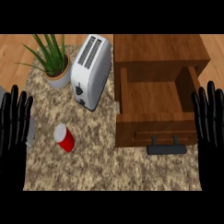

In [73]:
logging.info(f"VLM Input Image")
transformed_step['eagle_content']['image_inputs'][0]

### VLM Inference

![05-backbone-embedding-output.png](./assets/05-backbone-embedding-output.png)

In [88]:
# Data is converted into tensor format and with some implementation details; essentially same as dataset.transforms(data.get_step_data(0,0))
observations = unsqueeze_dict_values(dataset.get_step_data(0,0))
normalized_input = policy.apply_transforms(observations) 
logging.info(f"normalized_input keys: {normalized_input.keys()}")
logging.info(f"Normalized Input: {normalized_input}")

normalized_input keys: dict_keys(['state', 'state_mask', 'eagle_input_ids', 'eagle_attention_mask', 'eagle_pixel_values', 'eagle_image_sizes', 'embodiment_id'])
Normalized Input: {'state': tensor([[[ 1.4171e-03,  8.9942e-02,  1.6257e-02, -8.6321e-01, -1.8386e-02,
          -7.6656e-03, -1.3474e-02,  1.0000e+00,  9.9595e-01,  9.9987e-01,
          -5.0485e-01,  9.9983e-01,  9.9997e-01,  9.9991e-01, -2.9726e-02,
          -7.4097e-02, -1.0030e-02, -8.6321e-01,  9.0920e-04,  8.5650e-03,
          -1.5485e-02,  9.9956e-01,  9.9725e-01,  9.9995e-01, -5.0485e-01,
           1.0000e+00,  9.9996e-01,  9.9988e-01,  5.4446e-04,  6.1743e-04,
           6.8080e-04,  5.4762e-04,  1.4392e-03,  3.8208e-03,  1.0000e+00,
           1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  9.9999e-01,
           1.9315e-03,  2.1538e-03,  2.2959e-03,  1.8166e-03,  7.0515e-03,
           1.5272e-02,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           9.9998e-01,  9.9988e-01, -1.8372e-02, -5.5523e-03,

In [92]:
# Data is prepared for VLM 

backbone_inputs, action_inputs = policy.model.prepare_input(normalized_input)
logging.info(f"backbone_inputs keys: {backbone_inputs.keys()}")
logging.info(f"backbone_inputs: {backbone_inputs}")

backbone_inputs keys: dict_keys(['state', 'state_mask', 'eagle_input_ids', 'eagle_attention_mask', 'eagle_pixel_values', 'eagle_image_sizes', 'embodiment_id'])
backbone_inputs: {'state': tensor([[[ 1.4191e-03,  8.9844e-02,  1.6235e-02, -8.6328e-01, -1.8433e-02,
          -7.6599e-03, -1.3489e-02,  1.0000e+00,  9.9609e-01,  1.0000e+00,
          -5.0391e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00, -2.9785e-02,
          -7.4219e-02, -1.0010e-02, -8.6328e-01,  9.0790e-04,  8.5449e-03,
          -1.5503e-02,  1.0000e+00,  9.9609e-01,  1.0000e+00, -5.0391e-01,
           1.0000e+00,  1.0000e+00,  1.0000e+00,  5.4550e-04,  6.1798e-04,
           6.7902e-04,  5.4932e-04,  1.4420e-03,  3.8147e-03,  1.0000e+00,
           1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           1.9302e-03,  2.1515e-03,  2.2888e-03,  1.8158e-03,  7.0496e-03,
           1.5259e-02,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           1.0000e+00,  1.0000e+00, -1.8433e-02, -5.5542e-03, -

In [93]:
# Backbone inference
# https://blog.lukesalamone.com/posts/what-are-attention-masks/
# only keys with eagle_ prefix are passed to the backbone
backbone_output = policy.model.backbone(backbone_inputs)
logging.info(f"backbone_output keys: {backbone_output.keys()}")
logging.info(f"backbone_output: {backbone_output}")

backbone_output keys: dict_keys(['backbone_features', 'backbone_attention_mask'])
backbone_output: {'backbone_features': tensor([[[ 2.3460e-04, -8.8501e-03,  1.0803e-02,  ..., -7.7209e-03,
           1.0071e-02, -3.0273e-02],
         [ 2.6172e-01,  3.8477e-01, -3.4961e-01,  ...,  6.2500e-01,
           2.0469e+00,  1.0625e+00],
         [ 1.0156e+00,  2.1973e-01, -1.0703e+00,  ..., -1.3438e+00,
           9.6875e-01,  2.5156e+00],
         ...,
         [-1.7031e+00,  2.1094e-01,  4.5898e-01,  ...,  2.7539e-01,
          -9.0625e-01, -1.9629e-01],
         [-9.8047e-01, -2.1289e-01,  9.8047e-01,  ...,  1.4844e-01,
          -1.4141e+00,  6.5234e-01],
         [-6.2500e-01,  6.5625e-01,  2.7188e+00,  ...,  1.5000e+00,
          -8.3594e-01, -8.2812e-01]]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MulBackward0>), 'backbone_attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# Diffusion Model
![06-diffusion-model-input.png](./assets/06-diffusion-model-input.png)

In [94]:
logging.info(f"action_inputs keys: {action_inputs.keys()}")
logging.info(f"backbone_output keys: {backbone_output.keys()}")
logging.info(f"action_inputs: {action_inputs}")

action_inputs keys: dict_keys(['state', 'state_mask', 'eagle_input_ids', 'eagle_attention_mask', 'eagle_pixel_values', 'eagle_image_sizes', 'embodiment_id'])
backbone_output keys: dict_keys(['backbone_features', 'backbone_attention_mask'])
action_inputs: {'state': tensor([[[ 1.4191e-03,  8.9844e-02,  1.6235e-02, -8.6328e-01, -1.8433e-02,
          -7.6599e-03, -1.3489e-02,  1.0000e+00,  9.9609e-01,  1.0000e+00,
          -5.0391e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00, -2.9785e-02,
          -7.4219e-02, -1.0010e-02, -8.6328e-01,  9.0790e-04,  8.5449e-03,
          -1.5503e-02,  1.0000e+00,  9.9609e-01,  1.0000e+00, -5.0391e-01,
           1.0000e+00,  1.0000e+00,  1.0000e+00,  5.4550e-04,  6.1798e-04,
           6.7902e-04,  5.4932e-04,  1.4420e-03,  3.8147e-03,  1.0000e+00,
           1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           1.9302e-03,  2.1515e-03,  2.2888e-03,  1.8158e-03,  7.0496e-03,
           1.5259e-02,  1.0000e+00,  1.0000e+00,  1.0000e+00

In [ ]:
# The action head takes the backbone output and action inputs and outputs the action

# The action head encodes the state input based on embodiment specific MLP encoder: https://github.com/NVIDIA/Isaac-GR00T/blob/main/gr00t/model/action_head/flow_matching_action_head.py#L362
# The action head encodes the action features based on embodiment specific MLP encoder: https://github.com/NVIDIA/Isaac-GR00T/blob/main/gr00t/model/action_head/flow_matching_action_head.py#L362
# The initial action is initialized randomly: https://github.com/NVIDIA/Isaac-GR00T/blob/main/gr00t/model/action_head/flow_matching_action_head.py#L367
# The action_head encoded_hidden_states are from the vlm embedding:https://github.com/NVIDIA/Isaac-GR00T/blob/main/gr00t/model/action_head/flow_matching_action_head.py#L399

# 

action_head_outputs = policy.model.action_head.get_action(backbone_output, action_inputs)
logging.info(f"action_head_outputs keys: {action_head_outputs.keys()}")
logging.info(f"action_head_outputs: {action_head_outputs['action_pred'].size()}")



action_head_outputs keys: dict_keys(['action_pred'])
action_head_outputs: torch.Size([1, 16, 32])
